# Text-to-Python Code Generation using Seq2Seq Models

This notebook implements and compares four sequence-to-sequence architectures for generating Python code from natural language descriptions:

1. **Vanilla RNN Seq2Seq** 
2. **LSTM Seq2Seq** 
3. **LSTM with Attention** 
4. **Transformer** 

**Dataset**: CodeSearchNet Python 

## 1. Environment Setup and Data Loading

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import time
from datasets import load_dataset
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
# Load dataset
ds = load_dataset("Nan-Do/code-search-net-python")
print(ds)

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-ee77a7de79eb2a(…):   0%|          | 0.00/155M [00:00<?, ?B/s]

data/train-00001-of-00004-648b3bede2edf6(…):   0%|          | 0.00/139M [00:00<?, ?B/s]

data/train-00002-of-00004-1dfd72b171e6b2(…):   0%|          | 0.00/153M [00:00<?, ?B/s]

data/train-00003-of-00004-184ab6d0e3c690(…):   0%|          | 0.00/151M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/455243 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['repo', 'path', 'func_name', 'original_string', 'language', 'code', 'code_tokens', 'docstring', 'docstring_tokens', 'sha', 'url', 'partition', 'summary'],
        num_rows: 455243
    })
})


## 2. Data Preprocessing and Filtering

In [3]:
# Extract relevant columns
full_df = ds['train'].to_pandas()
df = full_df[['code', 'code_tokens', 'docstring', 'docstring_tokens']]

# Filter by sequence length constraints and sample
length_filter = (df['docstring_tokens'].map(len) <= 50) & (df['code_tokens'].map(len) <= 80)
filtered_data = df[length_filter]
sampled_data = filtered_data.sample(n=10000, random_state=42).reset_index(drop=True)

print(f"Sampled dataset shape: {sampled_data.shape}")
print("\nFirst few examples:")
print(sampled_data.head(3))

Sampled dataset shape: (10000, 4)

First few examples:
                                                code  \
0  def _lib(self, name, only_if_have=False):\n   ...   
1  def open(self):\n        """Opens an existing ...   
2  def hmac_sha1(self, key_handle, data, flags = ...   

                                         code_tokens  \
0  [def, _lib, (, self, ,, name, ,, only_if_have,...   
1  [def, open, (, self, ), :, try, :, self, ., gr...   
2  [def, hmac_sha1, (, self, ,, key_handle, ,, da...   

                                           docstring  \
0  Specify a linker library.\n\n        Example:\...   
1                           Opens an existing cache.   
2  Have the YubiHSM generate a HMAC SHA1 of 'data...   

                                    docstring_tokens  
0                   [Specify, a, linker, library, .]  
1                    [Opens, an, existing, cache, .]  
2  [Have, the, YubiHSM, generate, a, HMAC, SHA1, ...  


In [4]:
# Analyze token length statistics
stats_df = pd.DataFrame({
    'code_length': sampled_data['code_tokens'].apply(len),
    'docstring_length': sampled_data['docstring_tokens'].apply(len)
}).describe()

print("Dataset Statistics:")
print(stats_df)

Dataset Statistics:
        code_length  docstring_length
count  10000.000000        10000.0000
mean      48.047400           12.5361
std       15.613723            8.8588
min       20.000000            1.0000
25%       35.000000            7.0000
50%       46.000000           10.0000
75%       60.000000           15.0000
max       80.000000           50.0000


## 3. Tokenization and Numericalization

In [5]:
# Initialize CodeBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base", add_prefix_space=True)
VOCAB_SIZE = tokenizer.vocab_size
PAD_IDX = tokenizer.pad_token_id

print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Padding index: {PAD_IDX}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Vocabulary size: 50265
Padding index: 1


In [6]:
# Convert tokens to IDs
def tokenize_row(row):
    code_toks = [str(t) for t in row['code_tokens']]
    doc_toks = [str(t) for t in row['docstring_tokens']]
    
    code_ids = tokenizer(code_toks, is_split_into_words=True, 
                         truncation=True, padding='max_length', max_length=128)['input_ids']
    doc_ids = tokenizer(doc_toks, is_split_into_words=True, 
                        truncation=True, padding='max_length', max_length=64)['input_ids']
    
    return pd.Series({'code_ids': code_ids, 'docstring_ids': doc_ids})

tokenized_data = sampled_data.apply(tokenize_row, axis=1)
dataset = pd.concat([sampled_data, tokenized_data], axis=1)
print("\nTokenization complete!")


Tokenization complete!


In [7]:
# Split into train/validation/test sets
train_data, temp_data = train_test_split(dataset, test_size=0.40, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.50, random_state=42)

print(f"Train: {len(train_data)} | Validation: {len(val_data)} | Test: {len(test_data)}")

Train: 6000 | Validation: 2000 | Test: 2000


In [8]:
# Create DataLoaders
def create_dataloader(df, batch_size=64, shuffle=True):
    src_tensor = torch.tensor(df['code_ids'].tolist())
    trg_tensor = torch.tensor(df['docstring_ids'].tolist())
    dataset = TensorDataset(src_tensor, trg_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(train_data)
val_loader = create_dataloader(val_data)
test_loader = create_dataloader(test_data, shuffle=False)

print("DataLoaders ready!")

DataLoaders ready!


---
# MODEL 1: Vanilla RNN Seq2Seq

## 4. Vanilla RNN Architecture

In [9]:
class RNN_Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        
    def forward(self, src):
        embedded = self.embed(src)
        _, hidden = self.rnn(embedded)
        return hidden

class RNN_Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.out = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, token, hidden):
        embedded = self.embed(token)
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.out(output.squeeze(1))
        return prediction, hidden

class VanillaSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_ratio=0.5):
        batch_size, trg_len = trg.shape
        vocab_size = self.decoder.vocab_size
        
        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)
        hidden = self.encoder(src)
        
        token = trg[:, 0].unsqueeze(1)
        
        for t in range(1, trg_len):
            pred, hidden = self.decoder(token, hidden)
            outputs[:, t] = pred
            
            use_teacher = torch.rand(1).item() < teacher_ratio
            token = trg[:, t].unsqueeze(1) if use_teacher else pred.argmax(1).unsqueeze(1)
            
        return outputs

print("Vanilla RNN model defined")

Vanilla RNN model defined


## 5. Training Vanilla RNN

In [10]:
# Model hyperparameters
EMBED_DIM = 128
HIDDEN_DIM = 256
N_EPOCHS = 10
CLIP = 1

# Initialize Model 1
encoder1 = RNN_Encoder(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM)
decoder1 = RNN_Decoder(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM)
model1 = VanillaSeq2Seq(encoder1, decoder1, DEVICE).to(DEVICE)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model1 = nn.DataParallel(model1)

optimizer1 = optim.Adam(model1.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

Using 2 GPUs


In [11]:
# Training function
def train_model(model, loader, optimizer, criterion, clip):
    model.train()
    total_loss = 0
    
    for src, trg in loader:
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        # Reshape for loss computation
        output = output[:, 1:].reshape(-1, output.shape[-1])
        trg = trg[:, 1:].reshape(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

# Evaluation function
def eval_model(model, loader, criterion):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for src, trg in loader:
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            output = model(src, trg, 0)  # No teacher forcing
            
            output = output[:, 1:].reshape(-1, output.shape[-1])
            trg = trg[:, 1:].reshape(-1)
            
            loss = criterion(output, trg)
            total_loss += loss.item()
    
    return total_loss / len(loader)

print("Training functions ready")

Training functions ready


In [14]:
# Train Vanilla RNN with loss tracking
best_val_loss = float('inf')
print("Training Vanilla RNN Seq2Seq...\n")

# Store losses for plotting
train_losses_m1 = []
val_losses_m1 = []

for epoch in range(N_EPOCHS):
    start = time.time()
    
    train_loss = train_model(model1, train_loader, optimizer1, criterion, CLIP)
    val_loss = eval_model(model1, val_loader, criterion)
    
    # Store losses
    train_losses_m1.append(train_loss)
    val_losses_m1.append(val_loss)
    
    elapsed = time.time() - start
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model1.state_dict(), 'vanilla_rnn.pt')
    
    print(f'Epoch {epoch+1:02} | Time: {elapsed:.0f}s')
    print(f'  Train Loss: {train_loss:.3f} | PPL: {math.exp(train_loss):7.3f}')
    print(f'  Val Loss: {val_loss:.3f} | PPL: {math.exp(val_loss):7.3f}')

print("\nVanilla RNN training complete!")

Training Vanilla RNN Seq2Seq...

Epoch 01 | Time: 100s
  Train Loss: 6.206 | PPL: 495.629
  Val Loss: 6.829 | PPL: 923.912
Epoch 02 | Time: 100s
  Train Loss: 6.115 | PPL: 452.376
  Val Loss: 6.851 | PPL: 944.607
Epoch 03 | Time: 100s
  Train Loss: 6.022 | PPL: 412.396
  Val Loss: 6.882 | PPL: 974.367
Epoch 04 | Time: 99s
  Train Loss: 5.947 | PPL: 382.472
  Val Loss: 6.904 | PPL: 995.930
Epoch 05 | Time: 99s
  Train Loss: 5.863 | PPL: 351.679
  Val Loss: 6.931 | PPL: 1023.477
Epoch 06 | Time: 99s
  Train Loss: 5.773 | PPL: 321.393
  Val Loss: 6.957 | PPL: 1050.432
Epoch 07 | Time: 99s
  Train Loss: 5.710 | PPL: 301.937
  Val Loss: 6.936 | PPL: 1028.302
Epoch 08 | Time: 98s
  Train Loss: 5.618 | PPL: 275.272
  Val Loss: 6.992 | PPL: 1087.586
Epoch 09 | Time: 98s
  Train Loss: 5.546 | PPL: 256.181
  Val Loss: 7.026 | PPL: 1125.236
Epoch 10 | Time: 98s
  Train Loss: 5.505 | PPL: 245.902
  Val Loss: 7.034 | PPL: 1135.019

Vanilla RNN training complete!


In [15]:
# Evaluate on test set
model1.load_state_dict(torch.load('vanilla_rnn.pt'))
test_loss = eval_model(model1, test_loader, criterion)
print(f'Vanilla RNN Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f}')

Vanilla RNN Test Loss: 6.833 | Test PPL: 927.944


---
# MODEL 2: LSTM Seq2Seq

## 6. LSTM Architecture

In [16]:
class LSTM_Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout=0.5):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embed(src))
        _, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

class LSTM_Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout=0.5):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.out = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, token, hidden, cell):
        token = token.unsqueeze(1)
        embedded = self.dropout(self.embed(token))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(1))
        return prediction, hidden, cell

class LSTMSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_ratio=0.5):
        batch_size, trg_len = trg.shape
        vocab_size = self.decoder.vocab_size
        
        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)
        hidden, cell = self.encoder(src)
        
        token = trg[:, 0]
        
        for t in range(1, trg_len):
            pred, hidden, cell = self.decoder(token, hidden, cell)
            outputs[:, t] = pred
            
            use_teacher = torch.rand(1).item() < teacher_ratio
            token = trg[:, t] if use_teacher else pred.argmax(1)
            
        return outputs

print("LSTM model defined")

LSTM model defined


## 7. Training LSTM

In [17]:
# Initialize Model 2
encoder2 = LSTM_Encoder(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM)
decoder2 = LSTM_Decoder(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM)
model2 = LSTMSeq2Seq(encoder2, decoder2, DEVICE).to(DEVICE)

if torch.cuda.device_count() > 1:
    model2 = nn.DataParallel(model2)

optimizer2 = optim.Adam(model2.parameters())

In [18]:
# Train LSTM 
best_val_loss = float('inf')
print("Training LSTM Seq2Seq...\n")

# Store losses for plotting
train_losses_m2 = []
val_losses_m2 = []

for epoch in range(N_EPOCHS):
    start = time.time()
    
    train_loss = train_model(model2, train_loader, optimizer2, criterion, CLIP)
    val_loss = eval_model(model2, val_loader, criterion)
    
    # Store losses
    train_losses_m2.append(train_loss)
    val_losses_m2.append(val_loss)
    
    elapsed = time.time() - start
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model2.state_dict(), 'lstm_seq2seq.pt')
    
    print(f'Epoch {epoch+1:02} | Time: {elapsed:.0f}s')
    print(f'  Train Loss: {train_loss:.3f} | PPL: {math.exp(train_loss):7.3f}')
    print(f'  Val Loss: {val_loss:.3f} | PPL: {math.exp(val_loss):7.3f}')

print("\nLSTM training complete!")

Training LSTM Seq2Seq...

Epoch 01 | Time: 99s
  Train Loss: 7.495 | PPL: 1799.806
  Val Loss: 6.791 | PPL: 889.692
Epoch 02 | Time: 98s
  Train Loss: 6.510 | PPL: 671.920
  Val Loss: 6.735 | PPL: 841.224
Epoch 03 | Time: 98s
  Train Loss: 6.397 | PPL: 599.939
  Val Loss: 6.750 | PPL: 853.739
Epoch 04 | Time: 98s
  Train Loss: 6.317 | PPL: 553.670
  Val Loss: 6.736 | PPL: 842.575
Epoch 05 | Time: 99s
  Train Loss: 6.254 | PPL: 519.954
  Val Loss: 6.744 | PPL: 848.950
Epoch 06 | Time: 99s
  Train Loss: 6.202 | PPL: 493.859
  Val Loss: 6.786 | PPL: 885.527
Epoch 07 | Time: 98s
  Train Loss: 6.157 | PPL: 471.821
  Val Loss: 6.818 | PPL: 913.833
Epoch 08 | Time: 98s
  Train Loss: 6.115 | PPL: 452.762
  Val Loss: 6.790 | PPL: 889.214
Epoch 09 | Time: 98s
  Train Loss: 6.080 | PPL: 437.153
  Val Loss: 6.797 | PPL: 895.426
Epoch 10 | Time: 99s
  Train Loss: 6.048 | PPL: 423.311
  Val Loss: 6.838 | PPL: 932.348

LSTM training complete!


In [19]:
# Evaluate on test set
model2.load_state_dict(torch.load('lstm_seq2seq.pt'))
test_loss = eval_model(model2, test_loader, criterion)
print(f'LSTM Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f}')

LSTM Test Loss: 6.751 | Test PPL: 854.848


---
# MODEL 3: LSTM with Attention Mechanism

## 8. Attention-based LSTM Architecture

In [20]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim * 3, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: [batch, hidden_dim]
        # encoder_outputs: [batch, src_len, hidden_dim*2]
        
        src_len = encoder_outputs.shape[1]
        hidden_expanded = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        energy = torch.tanh(self.W(torch.cat((hidden_expanded, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        
        return torch.softmax(attention, dim=1)

class AttentionEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout=0.5):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc_hidden = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc_cell = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embed(src))
        outputs, (hidden, cell) = self.lstm(embedded)
        
        # Combine bidirectional hidden/cell states
        hidden = torch.tanh(self.fc_hidden(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        cell = torch.tanh(self.fc_cell(torch.cat((cell[-2,:,:], cell[-1,:,:]), dim=1)))
        
        return outputs, hidden, cell

class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout, attention):
        super().__init__()
        self.vocab_size = vocab_size
        self.attention = attention
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM((hidden_dim * 2) + embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear((hidden_dim * 3) + embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, token, hidden, cell, encoder_outputs):
        token = token.unsqueeze(1)
        embedded = self.dropout(self.embed(token))
        
        # Calculate attention weights
        attn_weights = self.attention(hidden, encoder_outputs).unsqueeze(1)
        
        # Weighted context vector
        context = torch.bmm(attn_weights, encoder_outputs)
        
        # Concatenate context with embedded input
        lstm_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden.unsqueeze(0), cell.unsqueeze(0)))
        
        # Final prediction
        prediction = self.fc(torch.cat((output.squeeze(1), context.squeeze(1), embedded.squeeze(1)), dim=1))
        
        return prediction, hidden.squeeze(0), cell.squeeze(0), attn_weights.squeeze(1)

class AttentionSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_ratio=0.5):
        batch_size, trg_len = trg.shape
        vocab_size = self.decoder.vocab_size
        
        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)
        encoder_outputs, hidden, cell = self.encoder(src)
        
        token = trg[:, 0]
        
        for t in range(1, trg_len):
            pred, hidden, cell, _ = self.decoder(token, hidden, cell, encoder_outputs)
            outputs[:, t] = pred
            
            use_teacher = torch.rand(1).item() < teacher_ratio
            token = trg[:, t] if use_teacher else pred.argmax(1)
            
        return outputs

print("Attention-based LSTM model defined")

Attention-based LSTM model defined


## 9. Training Attention Model

In [21]:
# Initialize Model 3
attention = BahdanauAttention(HIDDEN_DIM)
encoder3 = AttentionEncoder(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM)
decoder3 = AttentionDecoder(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, 0.5, attention)
model3 = AttentionSeq2Seq(encoder3, decoder3, DEVICE).to(DEVICE)

if torch.cuda.device_count() > 1:
    model3 = nn.DataParallel(model3)

optimizer3 = optim.Adam(model3.parameters())

In [22]:
# Train Attention Model with loss tracking
best_val_loss = float('inf')
print("Training LSTM with Attention...\n")

# Store losses for plotting
train_losses_m3 = []
val_losses_m3 = []

for epoch in range(N_EPOCHS):
    start = time.time()
    
    train_loss = train_model(model3, train_loader, optimizer3, criterion, CLIP)
    val_loss = eval_model(model3, val_loader, criterion)
    
    # Store losses
    train_losses_m3.append(train_loss)
    val_losses_m3.append(val_loss)
    
    elapsed = time.time() - start
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model3.state_dict(), 'attention_lstm.pt')
    
    print(f'Epoch {epoch+1:02} | Time: {elapsed:.0f}s')
    print(f'  Train Loss: {train_loss:.3f} | PPL: {math.exp(train_loss):7.3f}')
    print(f'  Val Loss: {val_loss:.3f} | PPL: {math.exp(val_loss):7.3f}')

print("\nAttention model training complete!")

Training LSTM with Attention...

Epoch 01 | Time: 139s
  Train Loss: 7.172 | PPL: 1302.943
  Val Loss: 6.725 | PPL: 832.739
Epoch 02 | Time: 138s
  Train Loss: 6.386 | PPL: 593.546
  Val Loss: 6.732 | PPL: 838.907
Epoch 03 | Time: 138s
  Train Loss: 6.218 | PPL: 501.904
  Val Loss: 6.741 | PPL: 846.638
Epoch 04 | Time: 138s
  Train Loss: 6.070 | PPL: 432.540
  Val Loss: 6.766 | PPL: 867.660
Epoch 05 | Time: 138s
  Train Loss: 5.904 | PPL: 366.607
  Val Loss: 6.767 | PPL: 868.406
Epoch 06 | Time: 138s
  Train Loss: 5.725 | PPL: 306.458
  Val Loss: 6.784 | PPL: 883.497
Epoch 07 | Time: 139s
  Train Loss: 5.535 | PPL: 253.290
  Val Loss: 6.855 | PPL: 948.556
Epoch 08 | Time: 138s
  Train Loss: 5.331 | PPL: 206.582
  Val Loss: 6.920 | PPL: 1012.040
Epoch 09 | Time: 138s
  Train Loss: 5.140 | PPL: 170.688
  Val Loss: 6.959 | PPL: 1052.765
Epoch 10 | Time: 138s
  Train Loss: 4.907 | PPL: 135.290
  Val Loss: 7.031 | PPL: 1131.584

Attention model training complete!


In [23]:
# Evaluate on test set
model3.load_state_dict(torch.load('attention_lstm.pt'))
test_loss = eval_model(model3, test_loader, criterion)
print(f'Attention LSTM Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f}')

Attention LSTM Test Loss: 6.739 | Test PPL: 844.949


## 10. Attention Visualization

In [24]:
def generate_with_attention(code_ids, model, device, max_len=50):
    """Generate docstring and capture attention weights"""
    model.eval()
    
    # Handle DataParallel wrapper
    actual_model = model.module if isinstance(model, nn.DataParallel) else model
    
    src = torch.LongTensor(code_ids).unsqueeze(0).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden, cell = actual_model.encoder(src)

    generated_ids = [tokenizer.cls_token_id]
    attention_weights = torch.zeros(max_len, len(code_ids))

    for i in range(max_len):
        token = torch.LongTensor([generated_ids[-1]]).to(device)
        
        with torch.no_grad():
            pred, hidden, cell, attn = actual_model.decoder(token, hidden, cell, encoder_outputs)
        
        attention_weights[i] = attn.squeeze(0).cpu()
        
        next_token = pred.argmax(1).item()
        generated_ids.append(next_token)
        
        if next_token == tokenizer.sep_token_id:
            break
            
    generated_tokens = [tokenizer.decode([idx]) for idx in generated_ids[1:]]
    source_tokens = [tokenizer.decode([idx]) for idx in code_ids]
    
    return generated_tokens, source_tokens, attention_weights[:len(generated_tokens)]

print("Attention generation function ready")

Attention generation function ready


In [25]:
def plot_attention(src_tokens, trg_tokens, attention):
    """Visualize attention weights as a heatmap"""
    fig, ax = plt.subplots(figsize=(14, 10))
    
    im = ax.matshow(attention.numpy(), cmap='viridis')
    fig.colorbar(im)

    ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=9)
    ax.set_yticklabels([''] + trg_tokens, fontsize=9)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.xlabel("Source Code Tokens", fontsize=12)
    plt.ylabel("Generated Docstring Tokens", fontsize=12)
    plt.title("Attention Weight Visualization", fontsize=14)
    plt.tight_layout()
    plt.show()

print("Attention plotting function ready")

Attention plotting function ready



=== Example 5 ===

Generated docstring:  Return  a  the  the  the  . </s>


/tmp/ipykernel_55/2793566263.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=9)
/tmp/ipykernel_55/2793566263.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + trg_tokens, fontsize=9)


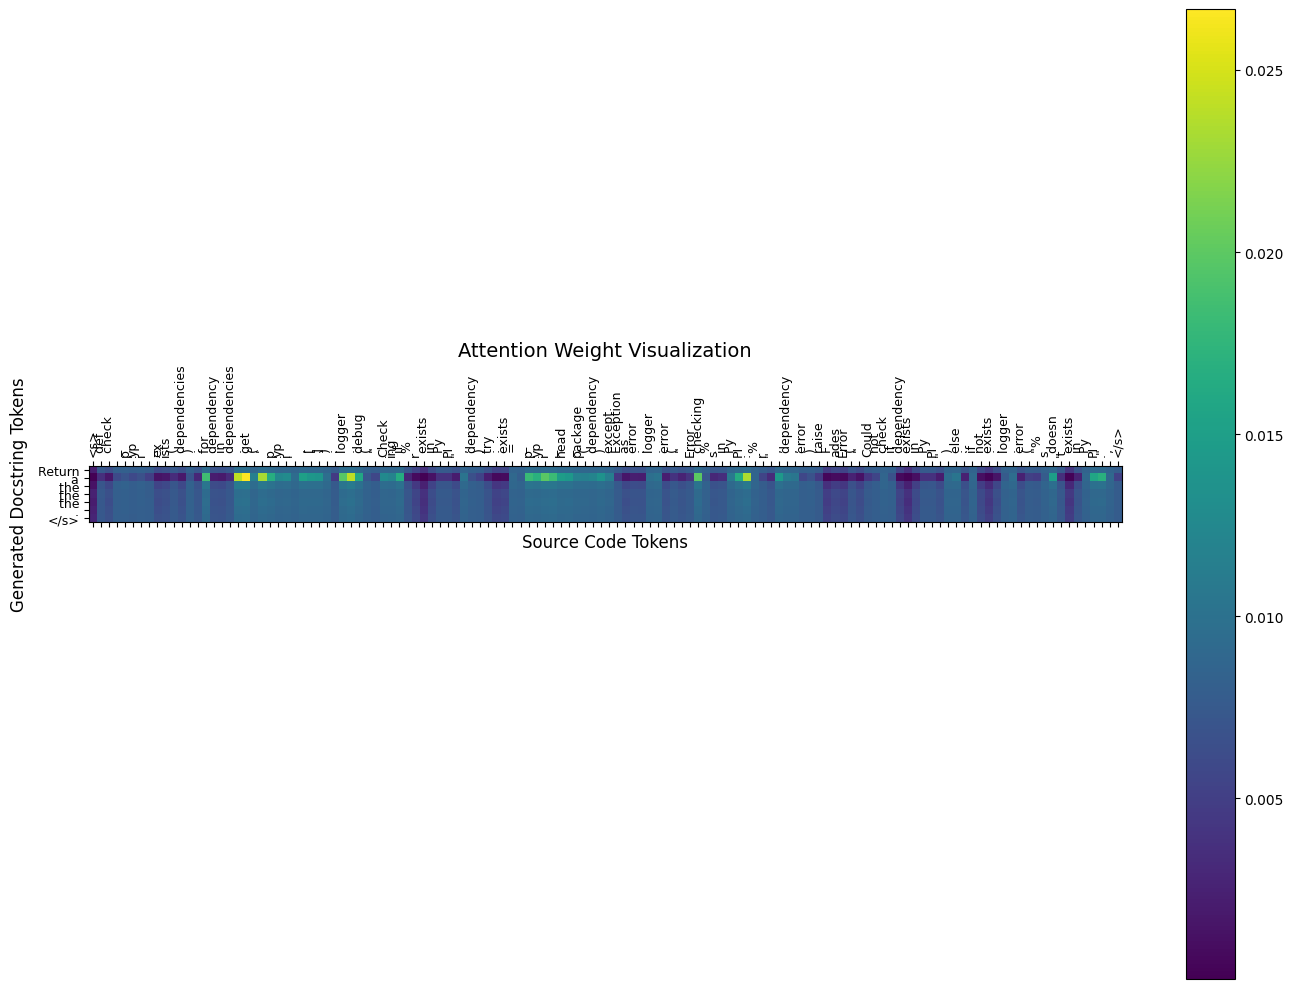


=== Example 15 ===

Generated docstring:  Return  the  the  the  the </s>


/tmp/ipykernel_55/2793566263.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=9)
/tmp/ipykernel_55/2793566263.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + trg_tokens, fontsize=9)


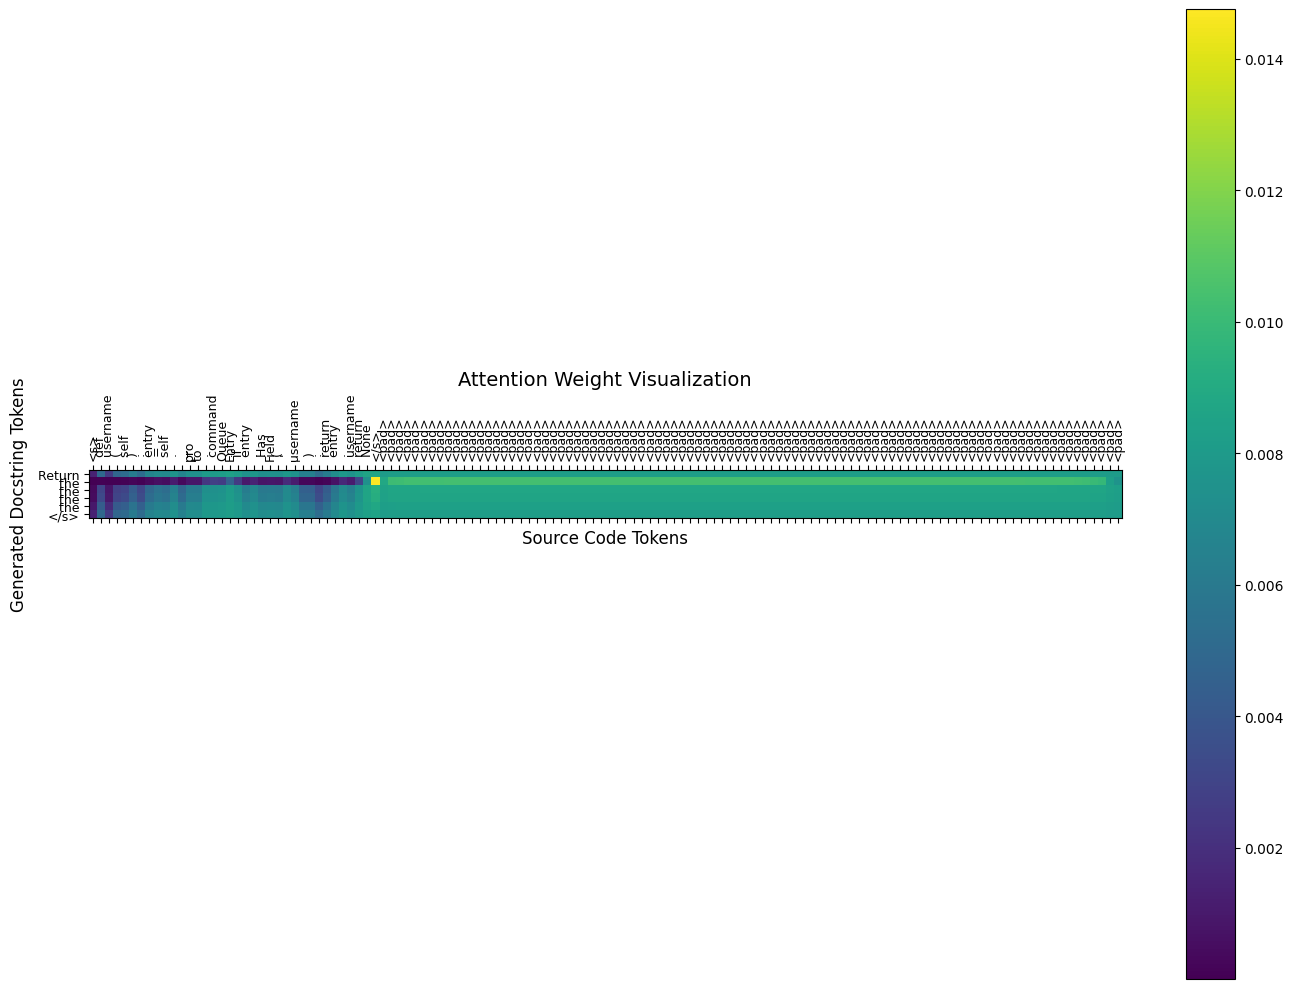


=== Example 25 ===

Generated docstring:  Return  the  the  the  the </s>


/tmp/ipykernel_55/2793566263.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=9)
/tmp/ipykernel_55/2793566263.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + trg_tokens, fontsize=9)


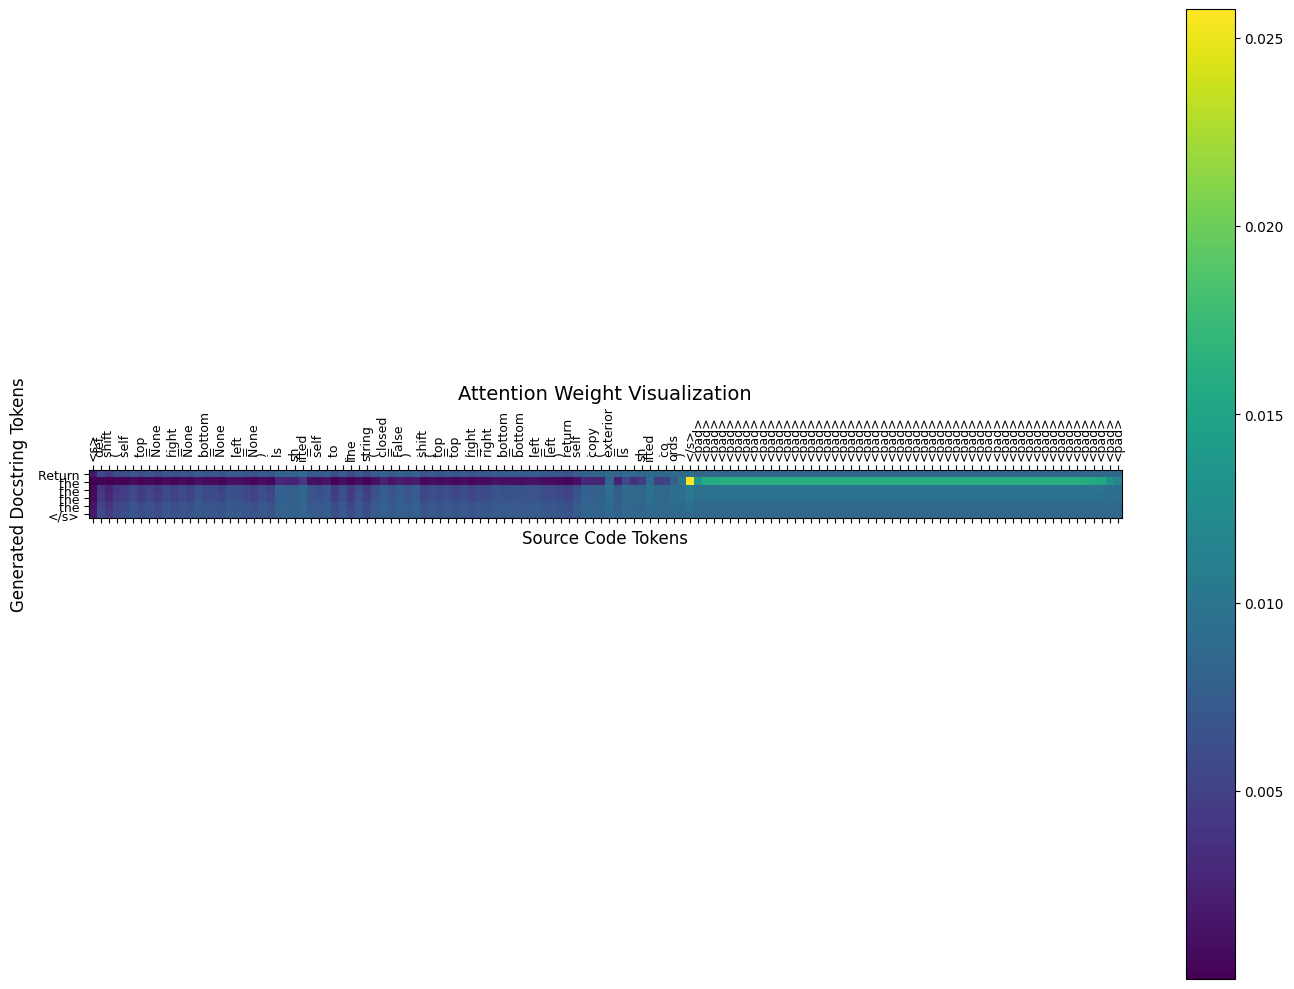

In [26]:
# Visualize attention for multiple test examples
for idx in [5, 15, 25]:
    print(f"\n=== Example {idx} ===")
    example_code = test_data.iloc[idx]['code_ids']
    
    generated, source, attn_matrix = generate_with_attention(example_code, model3, DEVICE)
    
    print(f"\nGenerated docstring: {' '.join(generated)}")
    plot_attention(source, generated, attn_matrix)

---
# MODEL 4: Transformer 

## 11. Transformer Architecture

In [37]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1)]
        return self.dropout(x)

class TransformerSeq2Seq(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=3, 
                 dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        
        self.fc_out = nn.Linear(d_model, vocab_size)

    def generate_square_mask(self, sz):
        """Generate causal mask for decoder"""
        mask = torch.triu(torch.ones(sz, sz), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def forward(self, src, trg):
        # Target mask to prevent attention to future tokens
        trg_mask = self.generate_square_mask(trg.size(1)).to(src.device)
        
        # Embed and add positional encoding
        src_emb = self.pos_encoder(self.embedding(src) * math.sqrt(self.d_model))
        trg_emb = self.pos_encoder(self.embedding(trg) * math.sqrt(self.d_model))
        
        # Pass through transformer
        output = self.transformer(src_emb, trg_emb, tgt_mask=trg_mask)
        
        return self.fc_out(output)

print("Transformer model defined")

Transformer model defined


## 12. Training Transformer

In [38]:
# Initialize Model 4 (Transformer)
D_MODEL = 256
NHEAD = 8
NUM_LAYERS = 3
FF_DIM = 512

model4 = TransformerSeq2Seq(VOCAB_SIZE, D_MODEL, NHEAD, NUM_LAYERS, FF_DIM, 0.1).to(DEVICE)

if torch.cuda.device_count() > 1:
    model4 = nn.DataParallel(model4)

optimizer4 = optim.Adam(model4.parameters(), lr=0.0001)

In [41]:
# Training and evaluation functions for Transformer
def train_transformer(model, loader, optimizer, criterion, clip):
    model.train()
    total_loss = 0
    
    for src, trg in loader:
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        
        # Transformer uses shifted target (teacher forcing)
        trg_input = trg[:, :-1]
        trg_output = trg[:, 1:]
        
        optimizer.zero_grad()
        output = model(src, trg_input)
        
        # Reshape for loss
        output = output.reshape(-1, output.shape[-1])
        trg_output = trg_output.reshape(-1)
        
        loss = criterion(output, trg_output)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

def eval_transformer(model, loader, criterion):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for src, trg in loader:
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            
            trg_input = trg[:, :-1]
            trg_output = trg[:, 1:]
            
            output = model(src, trg_input)
            
            output = output.reshape(-1, output.shape[-1])
            trg_output = trg_output.reshape(-1)
            
            loss = criterion(output, trg_output)
            total_loss += loss.item()
    
    return total_loss / len(loader)

print("Transformer training functions ready")

Transformer training functions ready


In [42]:
# Train Transformer Model with loss tracking
best_val_loss = float('inf')
print("Training Transformer...\n")

# Store losses for plotting
train_losses_m4 = []
val_losses_m4 = []

for epoch in range(N_EPOCHS):
    start = time.time()
    
    train_loss = train_transformer(model4, train_loader, optimizer4, criterion, CLIP)
    val_loss = eval_transformer(model4, val_loader, criterion)
    
    # Store losses
    train_losses_m4.append(train_loss)
    val_losses_m4.append(val_loss)
    
    elapsed = time.time() - start
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model4.state_dict(), 'transformer_seq2seq.pt')
    
    print(f'Epoch {epoch+1:02} | Time: {elapsed:.0f}s')
    print(f'  Train Loss: {train_loss:.3f} | PPL: {math.exp(train_loss):7.3f}')
    print(f'  Val Loss: {val_loss:.3f} | PPL: {math.exp(val_loss):7.3f}')

print("\nTransformer training complete!")

Training Transformer...

Epoch 01 | Time: 24s
  Train Loss: 8.799 | PPL: 6630.142
  Val Loss: 7.376 | PPL: 1597.668
Epoch 02 | Time: 24s
  Train Loss: 6.850 | PPL: 944.260
  Val Loss: 6.705 | PPL: 816.250
Epoch 03 | Time: 24s
  Train Loss: 6.491 | PPL: 659.164
  Val Loss: 6.566 | PPL: 710.535
Epoch 04 | Time: 24s
  Train Loss: 6.345 | PPL: 569.537
  Val Loss: 6.466 | PPL: 642.622
Epoch 05 | Time: 24s
  Train Loss: 6.230 | PPL: 507.857
  Val Loss: 6.395 | PPL: 598.927
Epoch 06 | Time: 24s
  Train Loss: 6.136 | PPL: 462.267
  Val Loss: 6.346 | PPL: 570.346
Epoch 07 | Time: 24s
  Train Loss: 6.045 | PPL: 421.872
  Val Loss: 6.276 | PPL: 531.852
Epoch 08 | Time: 24s
  Train Loss: 5.964 | PPL: 389.173
  Val Loss: 6.223 | PPL: 504.434
Epoch 09 | Time: 24s
  Train Loss: 5.889 | PPL: 360.941
  Val Loss: 6.177 | PPL: 481.640
Epoch 10 | Time: 24s
  Train Loss: 5.815 | PPL: 335.382
  Val Loss: 6.142 | PPL: 464.780

Transformer training complete!


In [43]:
# Evaluate on test set
model4.load_state_dict(torch.load('transformer.pt'))
test_loss = eval_transformer(model4, test_loader, criterion)
print(f'Transformer Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f}')

Transformer Test Loss: 6.153 | Test PPL: 470.011


## Training and Validation Loss Curves

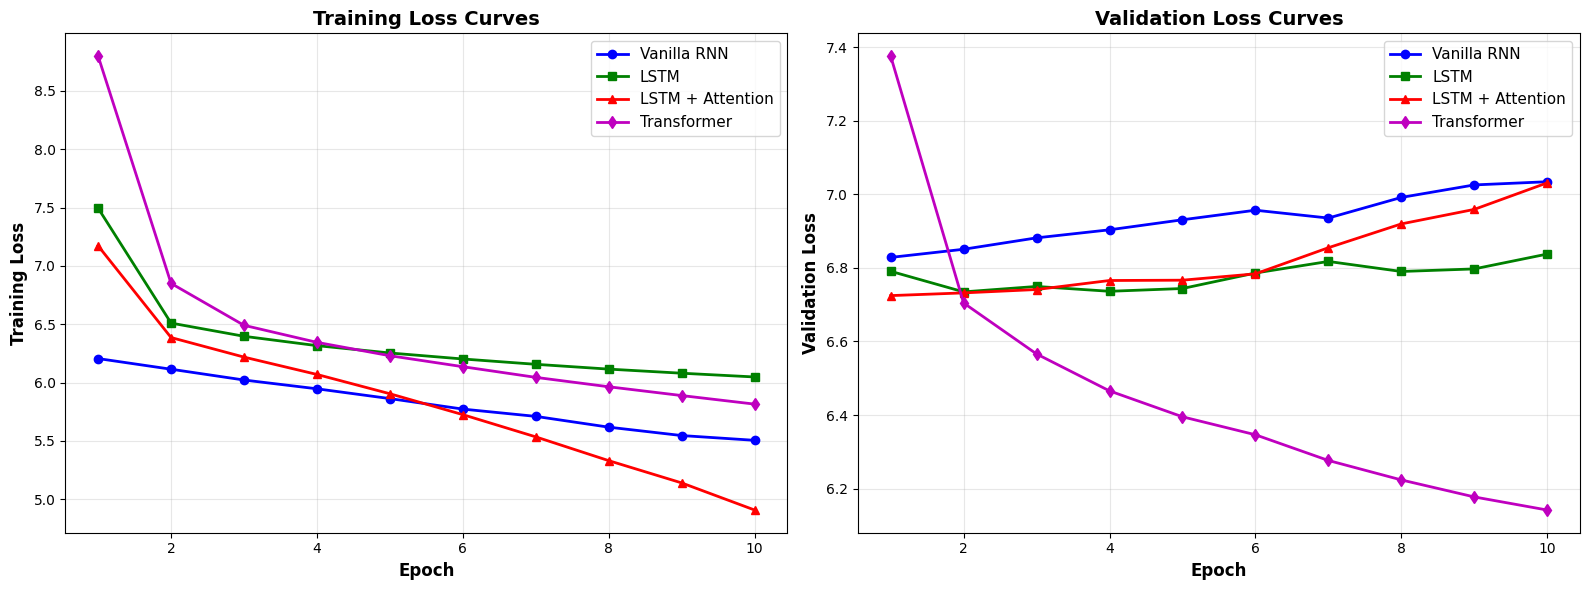


FINAL LOSSES AFTER 10 EPOCHS

Model                       Train Loss     Val Loss
------------------------------------------------------------
Vanilla RNN                      5.505        7.034
LSTM                             6.048        6.838
LSTM + Attention                 4.907        7.031
Transformer                      5.815        6.142


In [44]:
# Plot training and validation loss curves for all models
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Training Loss Comparison
epochs = range(1, N_EPOCHS + 1)
ax1.plot(epochs, train_losses_m1, 'b-o', label='Vanilla RNN', linewidth=2, markersize=6)
ax1.plot(epochs, train_losses_m2, 'g-s', label='LSTM', linewidth=2, markersize=6)
ax1.plot(epochs, train_losses_m3, 'r-^', label='LSTM + Attention', linewidth=2, markersize=6)
ax1.plot(epochs, train_losses_m4, 'm-d', label='Transformer', linewidth=2, markersize=6)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Training Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training Loss Curves', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Validation Loss Comparison
ax2.plot(epochs, val_losses_m1, 'b-o', label='Vanilla RNN', linewidth=2, markersize=6)
ax2.plot(epochs, val_losses_m2, 'g-s', label='LSTM', linewidth=2, markersize=6)
ax2.plot(epochs, val_losses_m3, 'r-^', label='LSTM + Attention', linewidth=2, markersize=6)
ax2.plot(epochs, val_losses_m4, 'm-d', label='Transformer', linewidth=2, markersize=6)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Validation Loss', fontsize=12, fontweight='bold')
ax2.set_title('Validation Loss Curves', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final losses for comparison
print("\n" + "="*60)
print("FINAL LOSSES AFTER {} EPOCHS".format(N_EPOCHS))
print("="*60)
print(f"\n{'Model':<25} {'Train Loss':>12} {'Val Loss':>12}")
print("-"*60)
print(f"{'Vanilla RNN':<25} {train_losses_m1[-1]:>12.3f} {val_losses_m1[-1]:>12.3f}")
print(f"{'LSTM':<25} {train_losses_m2[-1]:>12.3f} {val_losses_m2[-1]:>12.3f}")
print(f"{'LSTM + Attention':<25} {train_losses_m3[-1]:>12.3f} {val_losses_m3[-1]:>12.3f}")
print(f"{'Transformer':<25} {train_losses_m4[-1]:>12.3f} {val_losses_m4[-1]:>12.3f}")
print("="*60)

---
# EVALUATION AND COMPARISON

## 13. Performance by Docstring Length

In [45]:
def analyze_length_performance(model, data_df, tokenizer, device):
    """Evaluate model performance across different docstring lengths"""
    model.eval()
    
    length_buckets = {
        'Short (1-15)': [],
        'Medium (16-35)': [],
        'Long (36-50)': []
    }
    
    with torch.no_grad():
        for _, row in data_df.iterrows():
            src = torch.tensor([row['code_ids']]).to(device)
            trg = torch.tensor([row['docstring_ids']]).to(device)
            
            output = model(src, trg, 0)
            
            output = output[:, 1:].reshape(-1, output.shape[-1])
            trg = trg[:, 1:].reshape(-1)
            
            loss = nn.functional.cross_entropy(output, trg, ignore_index=PAD_IDX).item()
            
            # Categorize by length
            doc_len = len([t for t in row['docstring_tokens'] if t])
            if doc_len <= 15:
                length_buckets['Short (1-15)'].append(loss)
            elif doc_len <= 35:
                length_buckets['Medium (16-35)'].append(loss)
            else:
                length_buckets['Long (36-50)'].append(loss)

    print(f"{'Category':<20} | {'Avg Loss':<10} | {'Count':<6}")
    print("-" * 45)
    for category, losses in length_buckets.items():
        avg = sum(losses) / len(losses) if losses else 0
        print(f"{category:<20} | {avg:<10.4f} | {len(losses):<6}")

# Specialized function for Transformer
def analyze_transformer_length(model, data_df, tokenizer, device):
    model.eval()
    length_buckets = {'Short (1-15)': [], 'Medium (16-35)': [], 'Long (36-50)': []}
    
    with torch.no_grad():
        for _, row in data_df.iterrows():
            src = torch.tensor([row['code_ids']]).to(device)
            trg = torch.tensor([row['docstring_ids']]).to(device)
            
            trg_input = trg[:, :-1]
            trg_output = trg[:, 1:]
            output = model(src, trg_input)
            
            output = output.reshape(-1, output.shape[-1])
            trg_output = trg_output.reshape(-1)
            loss = nn.functional.cross_entropy(output, trg_output, ignore_index=PAD_IDX).item()
            
            doc_len = len([t for t in row['docstring_tokens'] if t])
            if doc_len <= 15:
                length_buckets['Short (1-15)'].append(loss)
            elif doc_len <= 35:
                length_buckets['Medium (16-35)'].append(loss)
            else:
                length_buckets['Long (36-50)'].append(loss)
    
    print(f"{'Category':<20} | {'Avg Loss':<10} | {'Count':<6}")
    print("-" * 45)
    for category, losses in length_buckets.items():
        avg = sum(losses) / len(losses) if losses else 0
        print(f"{category:<20} | {avg:<10.4f} | {len(losses):<6}")

print("\n--- Vanilla RNN ---")
model1.load_state_dict(torch.load('vanilla_rnn.pt'))
analyze_length_performance(model1, test_data, tokenizer, DEVICE)

print("\n--- LSTM ---")
model2.load_state_dict(torch.load('lstm_seq2seq.pt'))
analyze_length_performance(model2, test_data, tokenizer, DEVICE)

print("\n--- LSTM with Attention ---")
model3.load_state_dict(torch.load('attention_lstm.pt'))
analyze_length_performance(model3, test_data, tokenizer, DEVICE)

print("\n--- Transformer ---")
model4.load_state_dict(torch.load('transformer.pt'))
analyze_transformer_length(model4, test_data, tokenizer, DEVICE)


--- Vanilla RNN ---
Category             | Avg Loss   | Count 
---------------------------------------------
Short (1-15)         | 6.4461     | 1518  
Medium (16-35)       | 6.9500     | 394   
Long (36-50)         | 7.1739     | 88    

--- LSTM ---
Category             | Avg Loss   | Count 
---------------------------------------------
Short (1-15)         | 6.4160     | 1518  
Medium (16-35)       | 6.8411     | 394   
Long (36-50)         | 7.0534     | 88    

--- LSTM with Attention ---
Category             | Avg Loss   | Count 
---------------------------------------------
Short (1-15)         | 6.4147     | 1518  
Medium (16-35)       | 6.8115     | 394   
Long (36-50)         | 7.0437     | 88    

--- Transformer ---
Category             | Avg Loss   | Count 
---------------------------------------------
Short (1-15)         | 5.8216     | 1518  
Medium (16-35)       | 6.2468     | 394   
Long (36-50)         | 6.4825     | 88    


## 14. BLEU Score and Token Accuracy

In [48]:
!pip install evaluate sacrebleu -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [49]:
import evaluate

bleu = evaluate.load("sacrebleu")

def compute_metrics(model, loader, tokenizer, device):
    """Calculate BLEU, token accuracy, and exact match"""
    model.eval()
    
    predictions = []
    references = []
    token_accs = []
    exact_matches = 0
    total = 0

    with torch.no_grad():
        for src, trg in loader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, 0)
            pred_ids = output.argmax(-1)

            for i in range(src.shape[0]):
                total += 1
                
                # Decode predictions and references
                pred_text = tokenizer.decode(pred_ids[i], skip_special_tokens=True).strip()
                ref_text = tokenizer.decode(trg[i], skip_special_tokens=True).strip()
                
                predictions.append(pred_text)
                references.append([ref_text])

                # Exact match
                if pred_text == ref_text:
                    exact_matches += 1

                # Token accuracy
                ref_toks = trg[i][trg[i] != PAD_IDX]
                pred_toks = pred_ids[i][:len(ref_toks)]
                
                if len(ref_toks) > 0:
                    correct = (ref_toks == pred_toks).sum().item()
                    token_accs.append(correct / len(ref_toks))

    bleu_score = bleu.compute(predictions=predictions, references=references)
    
    return {
        "BLEU": round(bleu_score['score'], 2),
        "Token_Acc": round(np.mean(token_accs) * 100, 2),
        "Exact_Match": round((exact_matches / total) * 100, 2)
    }

print("Metric calculation function ready")

Metric calculation function ready


In [52]:
# Compute metrics for all models
results = []

models = [
    ('Vanilla RNN', model1, 'vanilla_rnn.pt'),
    ('LSTM', model2, 'lstm_seq2seq.pt'),
    ('LSTM + Attention', model3, 'attention_lstm.pt'),
    ('Transformer', model4, 'transformer.pt')
]

print("Evaluating models...\n")

# Helper function for Transformer metrics
def compute_transformer_metrics(model, loader, tokenizer, device):
    model.eval()
    predictions, references, token_accs, exact_matches, total = [], [], [], 0, 0
    
    with torch.no_grad():
        for src, trg in loader:
            src, trg = src.to(device), trg.to(device)
            trg_input = trg[:, :-1]
            output = model(src, trg_input)
            pred_ids = output.argmax(-1)
            
            for i in range(src.shape[0]):
                total += 1
                pred_text = tokenizer.decode(pred_ids[i], skip_special_tokens=True).strip()
                ref_text = tokenizer.decode(trg[i], skip_special_tokens=True).strip()
                predictions.append(pred_text)
                references.append([ref_text])
                if pred_text == ref_text:
                    exact_matches += 1

                ref_toks = trg[i, 1:][trg[i, 1:] != PAD_IDX]
                pred_toks = pred_ids[i][:len(ref_toks)]
                if len(ref_toks) > 0 and len(pred_toks) == len(ref_toks):
                    token_accs.append((ref_toks == pred_toks).sum().item() / len(ref_toks))
    
    bleu_score = bleu.compute(predictions=predictions, references=references)
    return {
        "BLEU": round(bleu_score['score'], 2),
        "Token_Acc": round(np.mean(token_accs) * 100, 2),
        "Exact_Match": round((exact_matches / total) * 100, 2)
    }

for name, model, path in models:
    print(f"Evaluating {name}...")
    model.load_state_dict(torch.load(path))
    model.to(DEVICE)
    
    if name == 'Transformer':
        metrics = compute_transformer_metrics(model, test_loader, tokenizer, DEVICE)
    else:
        metrics = compute_metrics(model, test_loader, tokenizer, DEVICE)
    
    results.append({
        "Model": name,
        "BLEU Score": metrics['BLEU'],
        "Token Accuracy (%)": metrics['Token_Acc'],
        "Exact Match (%)": metrics['Exact_Match']
    })

# Display comparison table
comparison_df = pd.DataFrame(results)
print("\n" + "="*60)
print("FINAL COMPARATIVE RESULTS")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

Evaluating models...

Evaluating Vanilla RNN...


Evaluating LSTM...


Evaluating LSTM + Attention...


Evaluating Transformer...



FINAL COMPARATIVE RESULTS
           Model  BLEU Score  Token Accuracy (%)  Exact Match (%)
     Vanilla RNN        0.07               17.07              0.0
            LSTM        0.05               17.05              0.0
LSTM + Attention        0.03               18.02              0.0
     Transformer        0.23               19.89              0.0
